<a href="https://colab.research.google.com/github/riblidezso/wigner_dl_demo/blob/master/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What if you don't have 1 million images to train on?

----

Most often than not, your problem will have different stuff than the Imagenet 1k or 5k or 22k categories. Do you have to collect another 1 million examples to achieve similarly good results? Luckily, NOT!

Parameters learned on the million images of Imagenet can help in other tasks too. This is called **transfer learning**.

### Using Imagenet parameters

Think about this: The low level features of images should be pretty similar on pictures about different objects. Therefore starting from something learned on Imagenet could be useful for other categories too!

Also the model weights obtained on Imagenet are probably closer to the best solution than a random initilization right? It should not be worse than that.


#### Feature extraction

A basic solution would be to use a representation created by an Imagenet pretrained model as input instead of the original inputs. Obviously not the predictions, but something intermediate e.g.: last convolutional layers.

This can be essentially implemented by 'freezing' the parameters of layers. You can be set Keras and other libraries not to update params of specific layers during. Probably you want to freeze the first some convolutional layers, and train the rest. This might be reasonable to avoid overfitting.

You can also use different classifiers on top of these features, after simply saving them.

#### Complete fine-tuning

Instead of freezing some layers you can also update the whole model. Basically start from an Imagenet trained model, change only the classifier layer and train a bit ('fine-tune') your dataset.

----


## Example dataset: Cats vs Dogs

![catvsdogs](https://storage.googleapis.com/kaggle-competitions/kaggle/5441/logos/front_page.png)

ILSVRC has cats and dogs, but many many kinds. Maybe you could add up predictions for cats and dogs, but actually we can do better.


25k images, cats/dogs

https://www.kaggle.com/c/dogs-vs-cats


### Download data from kaggle

In [12]:
!wget http://dkrib.web.elte.hu/deeplearning/wigner_demo/cats_dogs.zip

--2018-11-16 15:23:05--  http://dkrib.web.elte.hu/deeplearning/wigner_demo/cats_dogs.zip
Resolving dkrib.web.elte.hu (dkrib.web.elte.hu)... 157.181.1.225
Connecting to dkrib.web.elte.hu (dkrib.web.elte.hu)|157.181.1.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580349967 (553M) [application/zip]
Saving to: ‘cats_dogs.zip’

cats_dogs.zip       100%[===================>] 553.46M  10.1MB/s    in 60s     

2018-11-16 15:24:06 (9.21 MB/s) - ‘cats_dogs.zip’ saved [580349967/580349967]



In [0]:
!unzip cats_dogs.zip

In [3]:
!ls

cats_dogs  cats_dogs.zip  __MACOSX  sample_data


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


I split to train/validation with ~30% of the data in validation.

In [2]:
from glob import glob
cats = sorted(glob('cats_dogs/train/cat/*.jpg'))
dogs = sorted(glob('cats_dogs/train/dog/*.jpg'))
print 'training:',len(cats),len(dogs)

cats = sorted(glob('cats_dogs/validation/cat/*.jpg'))
dogs = sorted(glob('cats_dogs/validation/dog/*.jpg'))
print 'validation:',len(cats),len(dogs)

training: 0 0
validation: 0 0


### Let's check out some images

In [0]:
from PIL import Image

#### They are mostly easy

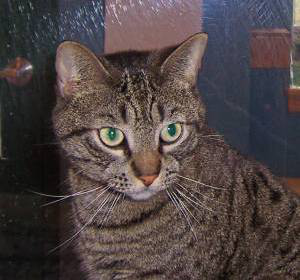

In [5]:
Image.open(cats[0])

Some are slightly harder

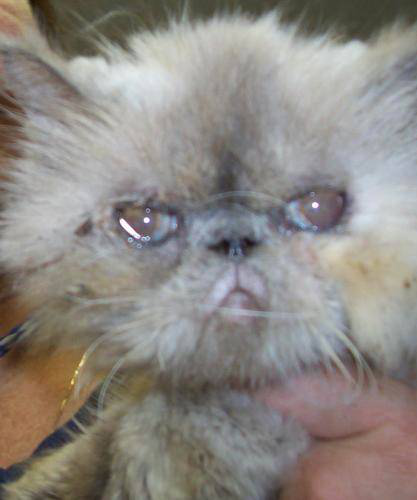

In [6]:
Image.open('cats_dogs/validation/cat/cat.1625.jpg')

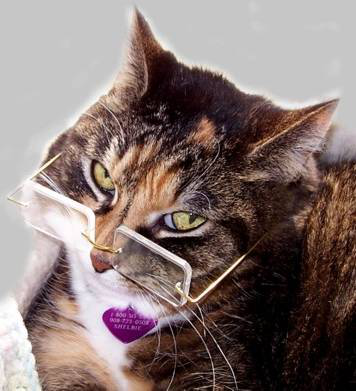

In [7]:
Image.open(cats[42])

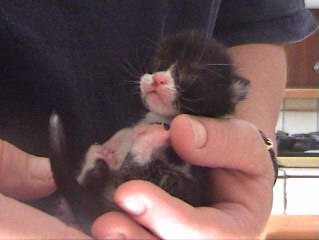

In [8]:
Image.open('cats_dogs/validation/cat/cat.1936.jpg')

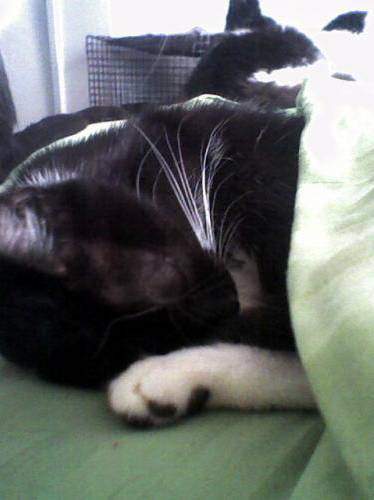

In [9]:
Image.open('cats_dogs/validation/cat/cat.10504.jpg')

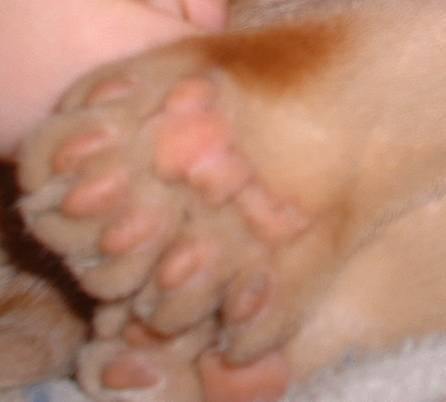

In [10]:
Image.open('cats_dogs/validation/cat/cat.10539.jpg')

### Some impossible :)

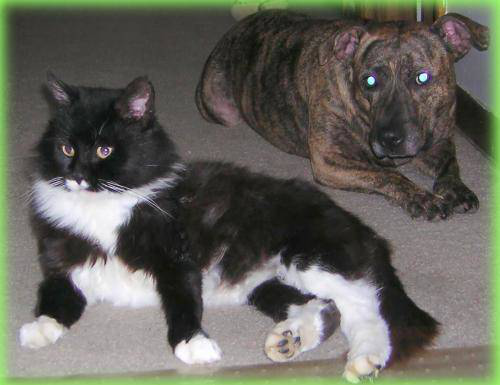

In [11]:
Image.open('cats_dogs/validation/cat/cat.10181.jpg')

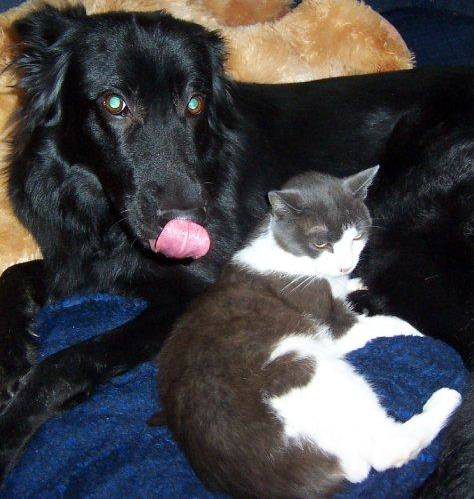

In [12]:
Image.open('cats_dogs/validation/cat/cat.10266.jpg')

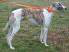

In [26]:
Image.open('cats_dogs/validation/dog/dog.1381.jpg')

And some just plain wrong ...

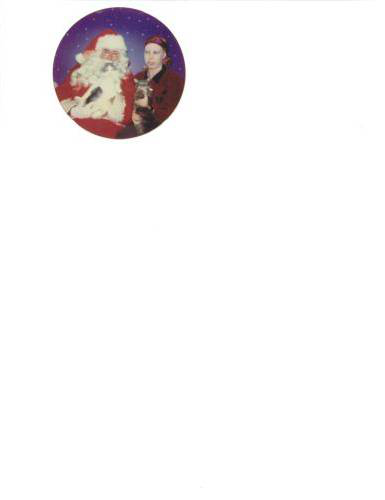

In [16]:
Image.open(cats[35])

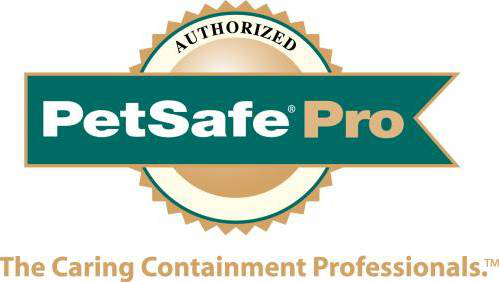

In [17]:
Image.open('cats_dogs/validation/cat/cat.10712.jpg')

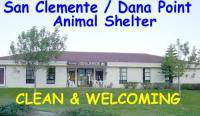

In [18]:
Image.open('cats_dogs/validation/dog/dog.1043.jpg')

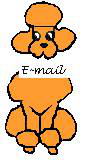

In [19]:
Image.open('cats_dogs/validation/dog/dog.1259.jpg')

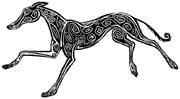

In [20]:
Image.open('cats_dogs/validation/dog/dog.1308.jpg')

In [0]:
Image.open('cats_dogs/validation/dog/dog.1773.jpg')

### Summary:

Out of 400 images 1 was a clear error and there were ~(5-10) not so easy ones.

#### Do not load 25000 images to memory, create a data generator for training

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Maybe I could use a preprocessing_function to use vgg16 normalization
# but there I got a bug in preprecessing_function whatever 

# teh generators
train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

# the 'flow's
train_generator = train_datagen.flow_from_directory(
        'cats_dogs/train',
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
        'cats_dogs/validation',
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary')

---


## Use the Vgg16 model




- 2nd place in ILSVRC 2014
- the best single model of the competition ( more tricks in the winner )
- [arxiv paper](https://arxiv.org/abs/1409.1556)

A few architectrural changes compared to LeNet.

* ReLU non-linearity instead of tanh or sigmoid
* move to 3x3 conv ( and 2 convolutions per blocks instead of 1 ) ('deeper')
* larger images -> repeat blocks multiple times to achieve large FOV for last conv untis  ('deeper')
* richer/more data: more filters ('wider' model)
* And a regularization layer: Dropout ([link to orignal paper](www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf))
    * during training randomly knock out a fraction of neurons (0 output)
    * during testing switch all on ( multiply outputs with the dropout probabilty )
    * the results is something like an 'ensemble' of slightly different networks
    * it's popularity has declined but still used in the best "inception" networks 


(Note the functional API.)


#### This time produce intermediate layer activations too!

In [0]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Dense, Dropout, Flatten

def VGG16():
    """
    Return a vgg16 model.
    
    Keras has a built in vgg16 model which omits Dropouts.
    I don't want to omit the dropouts as they are part of
    the original vgg16 model. therefore I have to define the
    vgg16 model myself.
    """
    img_input = Input(shape=(224,224,3),name='input')

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    b1c2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(b1c2)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    b2c2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(b2c2)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    b3c3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(b3c3)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    b4c3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(b4c3)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    b5c3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(b5c3)

    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dropout(0.5,name='Dropout1')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5,name='Dropout2')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(1000, activation='softmax', name='predictions')(x)

    vgg16 = Model(inputs=img_input, outputs=[x])
    
    return vgg16

[Download model parameters from Keras official](https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5)


Load weights

In [0]:
!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5

In [0]:
vgg16 = VGG16()  # initialize model
# load weights
vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels.h5.1')

### Customize model: replace the last layer with a 2 class layer

In [7]:
vgg16.layers.pop()  # pop lastlayer

# add one dense layer
inp = vgg16.input
out = vgg16.layers[-1].output
out = Dense(1, activation='sigmoid', name='predictions')(out)

vgg16_2 = Model(inp, out)  # link i/o to mondel

vgg16_2.summary()  # see it

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Train

Use a simple SGD with momemtum.

In [0]:
# use a simple SGD 
from keras import optimizers
sgd = optimizers.SGD(lr=0.001, decay=0, momentum=0.9, nesterov=True)

# compile model
vgg16_2.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])

Define a step learning schedule. It drops 10x after one epoch.

In [0]:
from keras.callbacks import LearningRateScheduler
def step_decay(epoch,base_lr=0.001,drop=0.1,epochs_drop=1.0):
    """Helper for learning rate decay."""
    lrate = base_lr * math.pow(drop,math.floor((epoch)/epochs_drop))
    return lrate

Train it and validate it.

In [0]:
# train and validate
vgg16_2.fit_generator(
        train_generator,
        steps_per_epoch=160,  # ~ 10000 examples per epoch
        epochs=3,
        validation_data=valid_generator,
        validation_steps=112,  # test on all validation images
        callbacks=[LearningRateScheduler(step_decay)])

----


### That's it


In only 10 minutes we trained a more than 98% accurate classifier!

4 years ago, when vgg16 was the state of the art that would be good for a [2nd place on kaggle](https://www.kaggle.com/c/dogs-vs-cats/leaderboard). Now when a lot more models are available, you can do [slightly better](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/leaderboard).


---

----


## Additional notes


#### Transfer learning is generalization

Imagenet trained models not only generalize to the unseen test dataset from the same categories, but also other unseen image recognition problems too!

#### Fine tuning is regularisation

Fine tuning can be thought of as a regularization. You start from Imagenet and train only for a short time. Therefore the weights are restricted to be close to the originals. Also training error is not reduced compared to a from scratch overfitted model, but the validation error is lower!


#### Catastrophic forgetting

If you train for too long on the new dataset, the parameters could go far from originals and can easily start to overfit and become worse!


#### Many many pretrained models are available

Caffe library has the largest [Model zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo) but Keras also features the most [important ones](https://keras.io/applications/).